In [1]:
import torch.nn          as nn
import torch.optim       as optim
import GM_library        as GML
import numpy             as np
import matplotlib.pyplot as plt
import torch

from os                   import path, listdir
from torch.utils.data     import random_split
from torch_geometric.data import Data

import sys
sys.path.append('../')
import MP.MP_library as MPL

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Machine-learning parameters
n_epochs      = 1000
batch_size    = 128
learning_rate = 0.0001

# Number of diffusing and denoising steps
n_t_steps = 10

# Decay of parameter alpha
noise_contribution = 0.15
alpha_decay = 0.5 * (1 - noise_contribution**2)

# Dropouts for node and edge models (independent of each other)
dropout_node = 0.2
dropout_edge = 0.2

# Graph embedding

In [142]:
import importlib
importlib.reload(GML)
importlib.reload(MPL)

<module 'MP.MP_library' from '/Users/cibran/Work/UPC/GenerativeModels/../MP/MP_library.py'>

In [134]:
# Read POSCAR
cell, composition, concentration, positions = MPL.information_from_VASPfile('.',
                                                                            'unitcell')

# Generate POSCAR covering the box
nodes, edges, attributes, _, _, _ = GML.graph_POSCAR_encoding(cell,
                                                              composition,
                                                              concentration,
                                                              positions)

# Construct temporal graph structure
graph = Data(x=nodes,
             edge_index=edges,
             edge_attr=attributes
            )

In [143]:
GML.POSCAR_graph_encoding(graph, cell, file_name=f'CONTCAR', POSCAR_directory='./')

13 41 59 13.52558 17.100769 19.221674 3.914984568890137 16.64659718039427


<_io.TextIOWrapper name='.//CONTCAR' mode='w' encoding='UTF-8'>

# Diffusion

In [3]:
graph = GML.get_random_graph(5, 1)

graph.x         = torch.abs(graph.x)
graph.edge_attr = torch.abs(graph.edge_attr)

In [4]:
import importlib
importlib.reload(GML)

<module 'GM_library' from '/Users/cibran/Work/UPC/GenerativeModels/GM_library.py'>

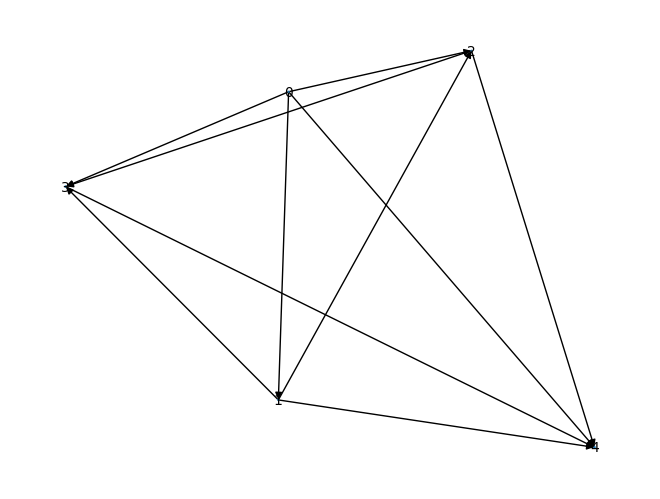

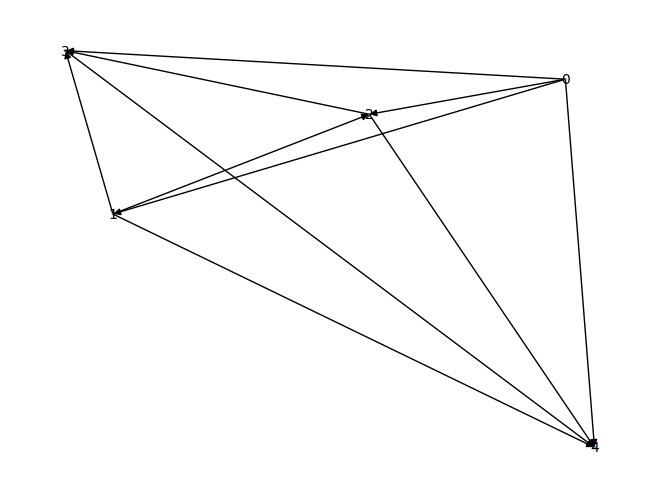

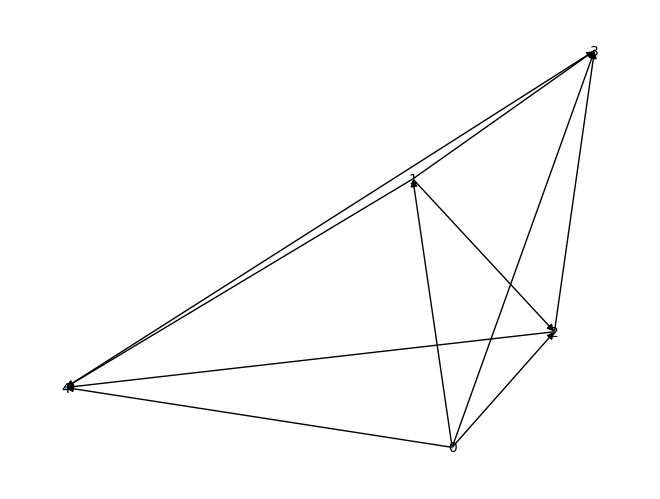

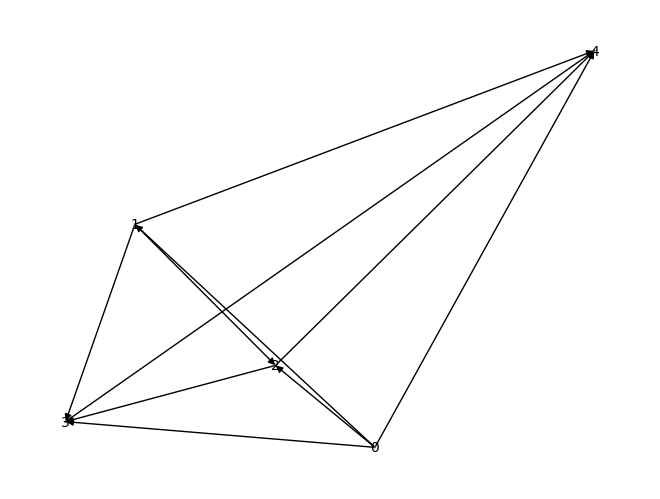

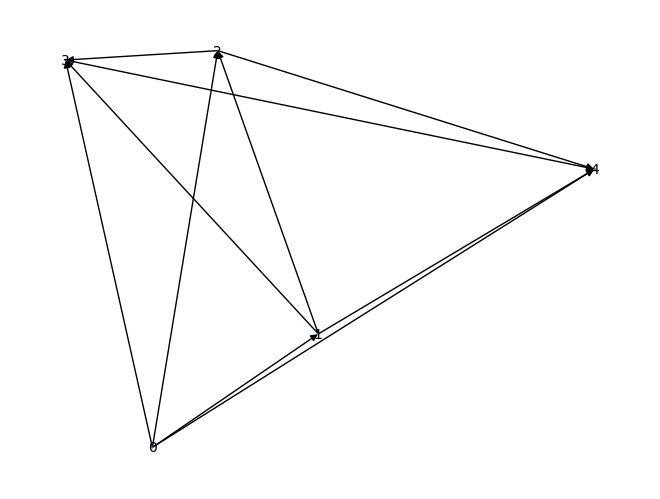

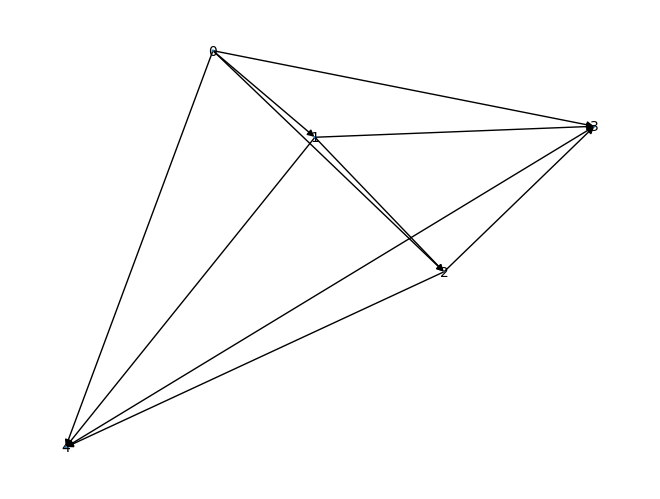

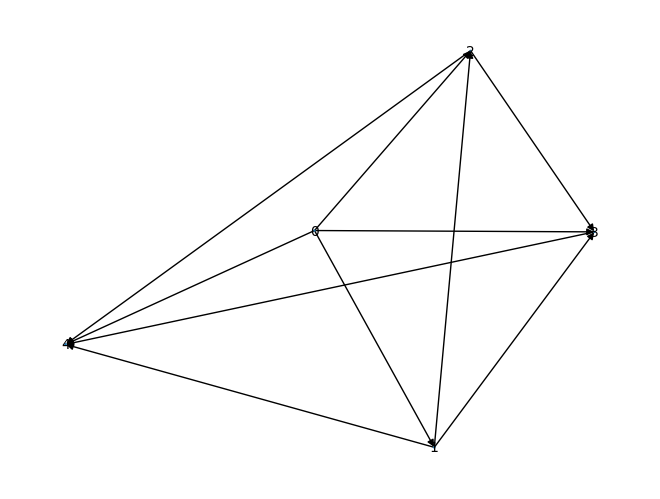

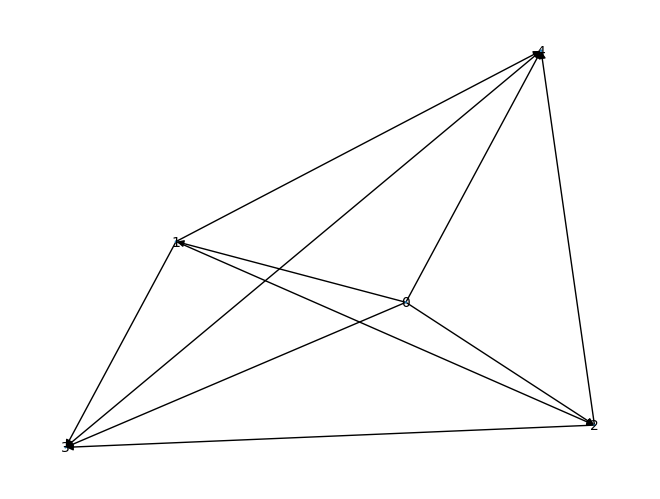

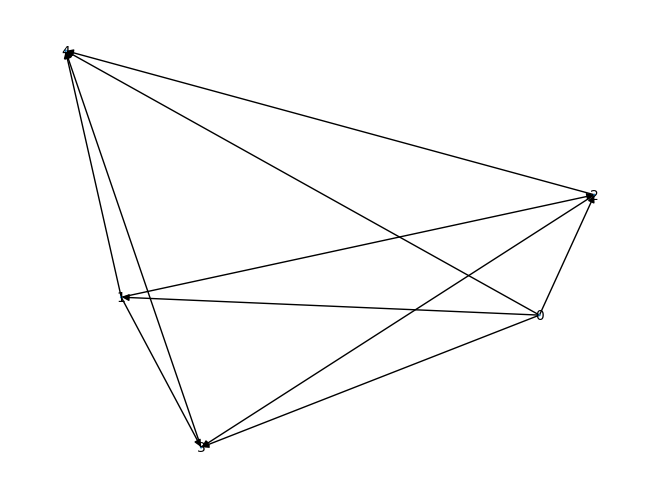

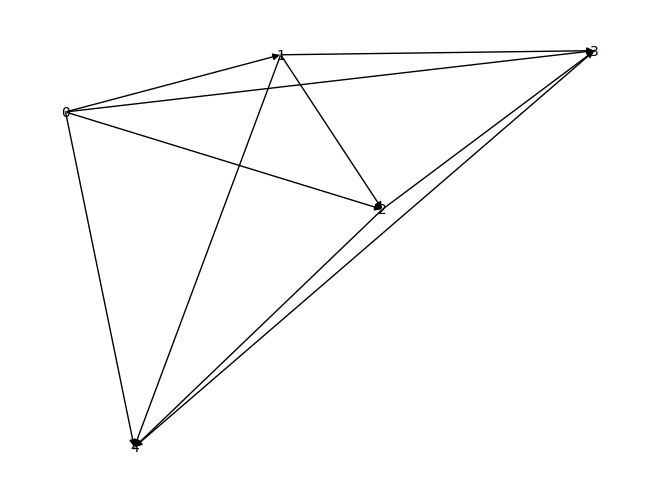

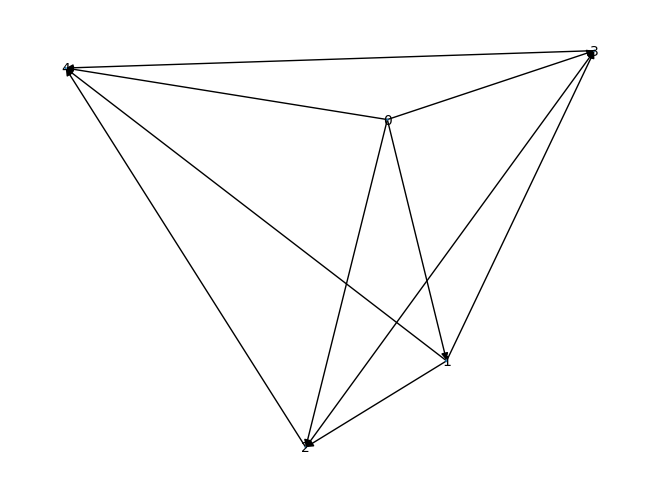

In [5]:
diffused_graph, all_graphs = GML.diffuse(graph, n_t_steps,
                                         s=alpha_decay, plot_steps=True)

In [6]:
# Extract features and attributes from each graph
all_xs    = []
all_attrs = []
for graph in all_graphs:
    all_xs.append(graph.x)
    all_attrs.append(graph.edge_attr)

# Each row corresponds to a different feature/edge
all_xs_concat    = torch.hstack(all_xs)
all_attrs_concat = torch.vstack(all_attrs).T

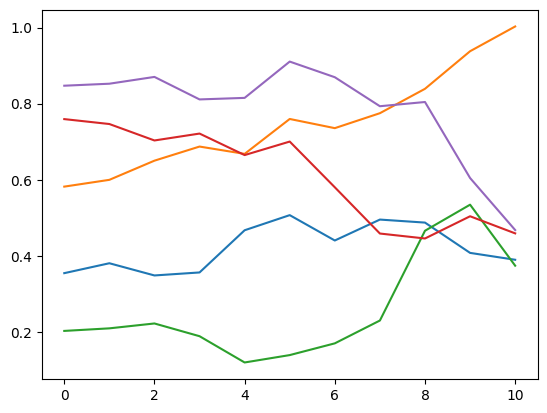

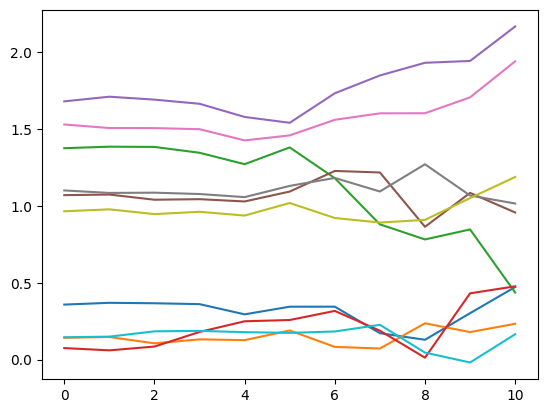

In [7]:
# Plot the evolution of features
for feature in all_xs_concat:
    feature_evolution = feature.detach().cpu().numpy()
    plt.plot(feature_evolution)
plt.show()

# Plot the evolution of edge attributes
for attribute in all_attrs_concat:
    attribute_evolution = attribute.detach().cpu().numpy()
    plt.plot(attribute_evolution)
plt.show()

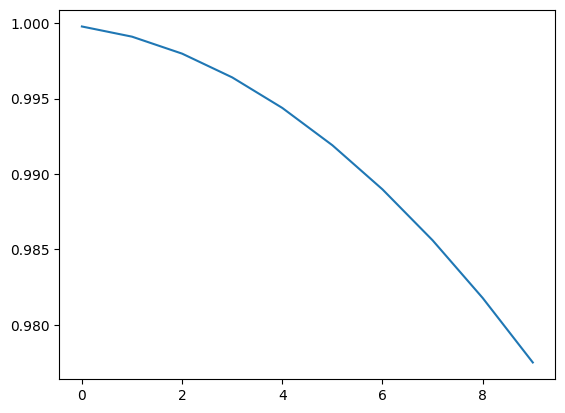

In [8]:
# Plot alpha_t parameter
alphas = GML.get_alpha_t(np.arange(1, n_t_steps+1), n_t_steps, s=alpha_decay)
plt.plot(alphas)